In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

import nltk
from nltk.stem.snowball import SnowballStemmer
import re

In [109]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [110]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [111]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [112]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [113]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [114]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [115]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [116]:
df_train.shape

(7613, 5)

In [117]:
df_test.shape

(3263, 4)

In [118]:
df_train.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [119]:
df_train.keyword.value_counts().sort_values(ascending = False)

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
harm                     41
body%20bags              41
siren                    40
windstorm                40
twister                  40
collided                 40
fear                     40
evacuate                 40
outbreak                 40
whirlwind                39
wrecked                  39
collision                39
wreckage                 39
derailment               39
earthquake               39
flames                   39
explosion                39
weapons                  39
weapon                   39
hellfire                 39
sinkhole                 39
sunk                     39
famine                   39
blaze                    38
bombed                   38
injury                   38
hurricane                38
upheaval                 38
fire                     38
typhoon                  38
fatal               

In [120]:
df_train["text_words"] = df_train.text.apply(lambda x: len(x.split()))
df_test["text_words"] = df_test.text.apply(lambda x: len(x.split()))

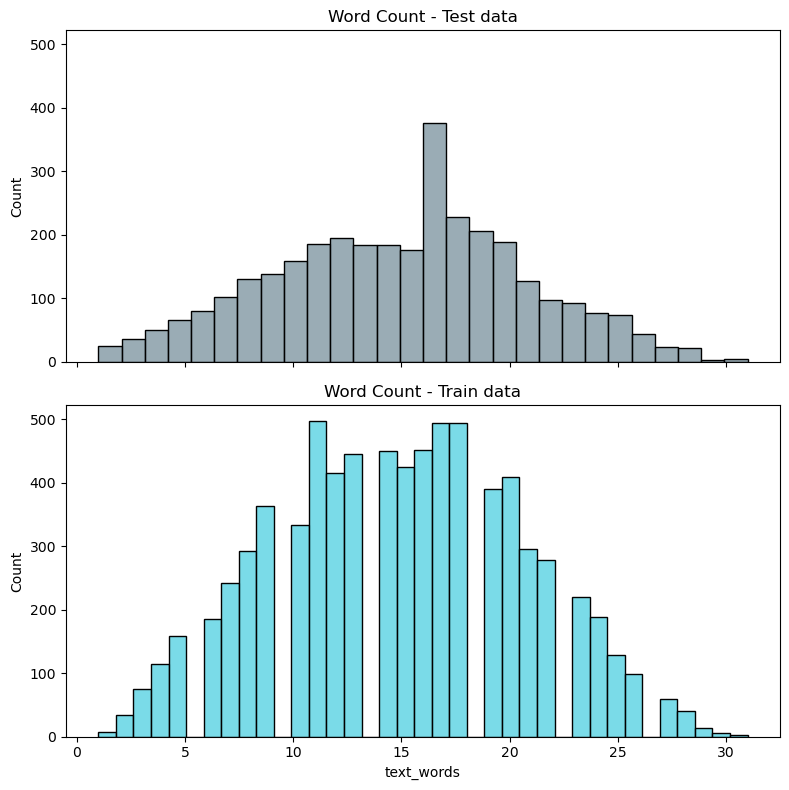

In [121]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_test, x=df_test['text_words'], color='#78909c', ax=axes[0]).set(title='Word Count - Test data')
sns.histplot(data=df_train, x=df_train['text_words'], color='#4dd0e1', ax=axes[1]).set(title='Word Count - Train data');

# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

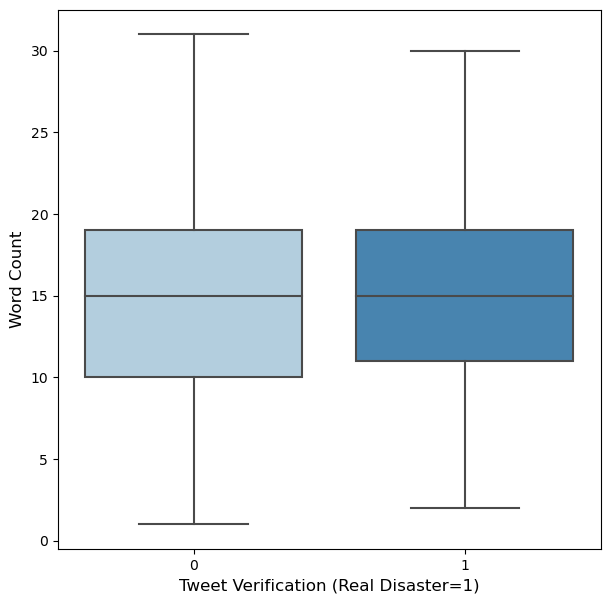

In [122]:
#df_train.boxplot(by ='target', column =['text_words'], grid = False);

plt.figure(figsize=(7,7))
word_count = sns.boxplot(x='target', y='text_words', data=df_train, palette = "Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Word Count', fontsize=12);

Note: the word count for 'real' and 'not real' disasters has a similar distribution, with a slightly shorter word count for 'not real' disasters

In [123]:
#word_count vs character_count
df_train['character_count'] = df_train['text'].str.len()
df_test['character_count'] = df_test['text'].str.len()

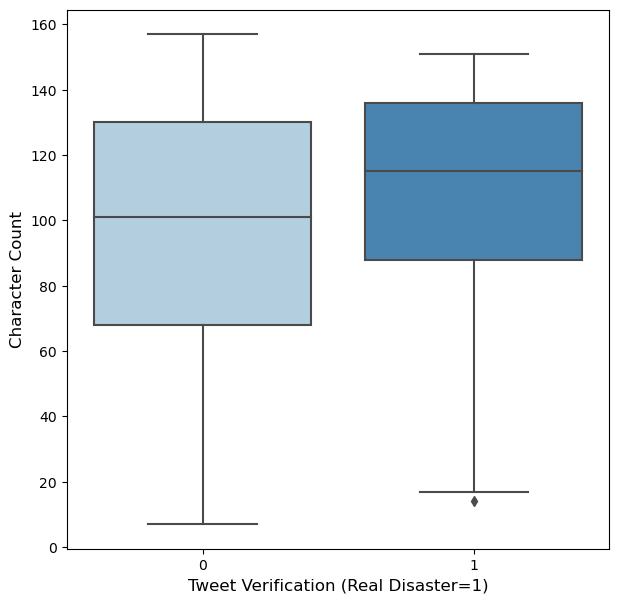

In [124]:
plt.figure(figsize=(7,7))
word_count = sns.boxplot(x='target', y='character_count', data=df_train, palette = "Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Character Count', fontsize=12);

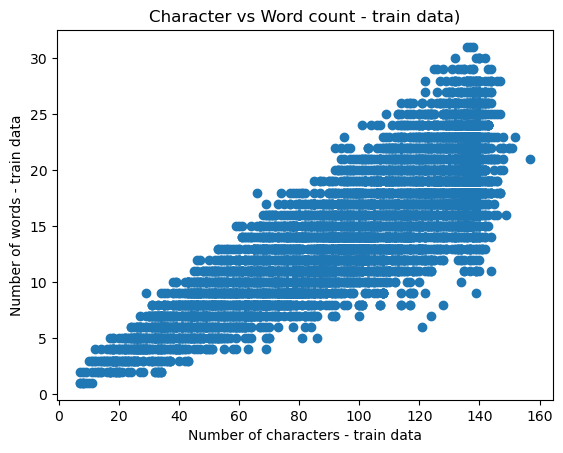

In [125]:
plt.scatter(df_train["character_count"], df_train["text_words"])

plt.xlabel("Number of characters - train data")
plt.ylabel("Number of words - train data")
plt.title("Character vs Word count - train data)")

plt.show()

In [126]:
df_train_target = df_train.groupby(['target']).aggregate({'character_count':'mean','text_words':'mean'})
df_train_target.reset_index()

,target,character_count,text_words
0,0,95.706817,14.704744
1,1,108.113421,15.167533


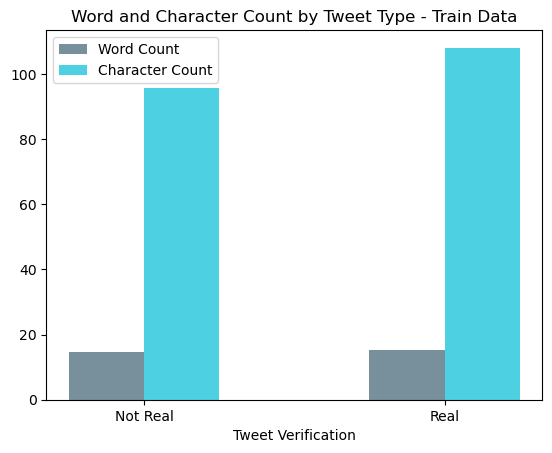

In [127]:
plt.bar(np.arange(2), df_train_target['text_words'], color = '#78909c',
        width = 0.25,
        label='Word Count')
plt.bar(np.arange(2)+.25, df_train_target["character_count"], color = '#4dd0e1',
        width = 0.25,
        label='Character Count')
  
plt.xlabel("Tweet Verification")
plt.title("Word and Character Count by Tweet Type - Train Data")

plt.xticks(np.arange(2)+.25/2,['Not Real', 'Real'])
plt.legend()

  
plt.show()

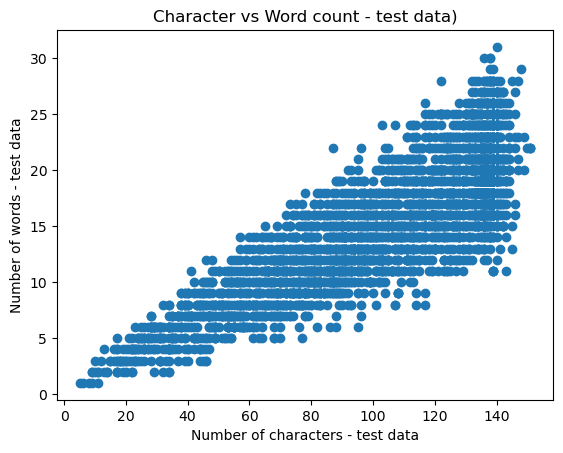

In [128]:
plt.scatter(df_test["character_count"], df_test["text_words"])

plt.xlabel("Number of characters - test data")
plt.ylabel("Number of words - test data")
plt.title("Character vs Word count - test data)")

plt.show()

In [129]:
filtered_df_train = df_train.dropna(subset = ['keyword'])

#df_train['count_keyword'] = df_train.apply(lambda x: x['text'].count(x['keyword']), axis=1)
filtered_df_train['count_keyword'] = [x.text.count(x.keyword) for x in filtered_df_train.itertuples()]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_75216/1697830117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_train['count_keyword'] = [x.text.count(x.keyword) for x in filtered_df_train.itertuples()]


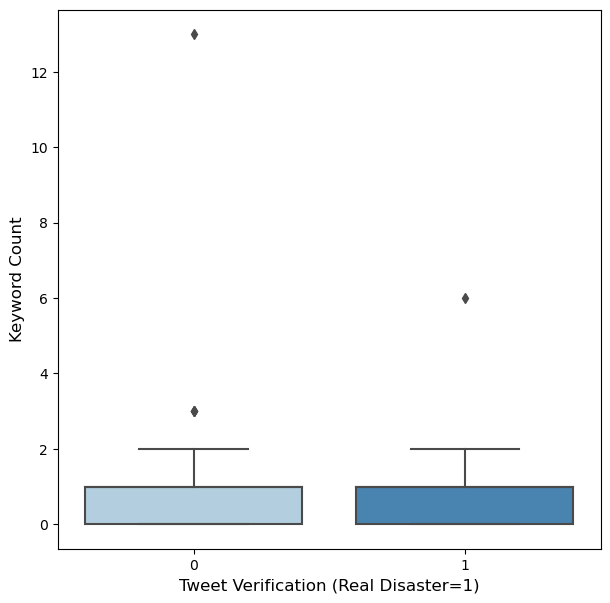

In [130]:
plt.figure(figsize=(7,7))
keyword_count = sns.boxplot(x='target', y='count_keyword', data=filtered_df_train, palette="Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Keyword Count', fontsize=12);

Note: Consider removing tweets where keyword count exceeds 2 per tweet

### Model

#### Lemmatize

In [131]:
from nltk.stem import WordNetLemmatizer
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

df_train['text_lemmatized'] = df_train.text.apply(lemmatize_text)

In [132]:
snow_stemmer = SnowballStemmer(language='english')
stem_words = []
stem_words_ = []

words = [nltk.word_tokenize(x) for x in df_train["text"]]
for w in words:
    for l in w:
        stemmed_words = snow_stemmer.stem(l)
        stem_words.append(stemmed_words)
words_ = pd.Series(words)
for i in words_:
    x = " ".join(i)
    stem_words_.append(x)

df_train["text_stemmed"] = stem_words_

In [133]:
X = df_train["text_lemmatized"]
y = df_train["target"]

In [134]:
X_train, X_traintest, y_train, y_traintest = train_test_split(X,
                                                    y,
                                                    random_state=42)

#### Bernoulli

**Count Vector**

In [135]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [136]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [137]:
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [138]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [139]:
gs.best_score_

0.7959371369017562

In [140]:
print(gs.score(X_train,y_train))
print(gs.score(X_traintest,y_traintest))

0.8637239446488001
0.8046218487394958


**TFIDF**

In [141]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [142]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [143]:
gs_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [144]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [145]:
gs_tvec.best_score_

0.7959371369017562

In [146]:
print(gs_tvec.score(X_train,y_train))
print(gs_tvec.score(X_traintest,y_traintest))

0.8637239446488001
0.8046218487394958


#### Logistic Regression

**Count Vector**

In [147]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [148]:
gs_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [149]:
gs_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [150]:
gs_logr.best_score_

0.7903303244304394

In [151]:
print(gs_logr.score(X_train,y_train))
print(gs_logr.score(X_traintest,y_traintest))

0.8935014888772114
0.8014705882352942


**TFIDF**

In [152]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [153]:
gs_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                pipe_params_tvec, 
                  cv = 5)

In [154]:
gs_tvec_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [155]:
gs_tvec_logr.best_score_

0.7880536168997914

In [156]:
print(gs_tvec_logr.score(X_train,y_train))
print(gs_tvec_logr.score(X_traintest,y_traintest))

0.8999824837975127
0.7967436974789915


#### ADA Boost + Logistic Regression

In [157]:
abc = AdaBoostClassifier(random_state = 42)

In [158]:
cv = CountVectorizer(min_df=2)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_traintest)

In [159]:
dt_abc = abc.fit(X_train_cv, y_train)

In [160]:
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_traintest))

0.7708880714661062
0.7473739495798319


#### Decision Tree

In [161]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [162]:
dtc = DecisionTreeClassifier()

In [163]:
dt = dtc.fit(X_train_cv, y_train)

In [164]:
print(dt.score(X_train_cv, y_train))
print(dt.score(X_test_cv, y_traintest))

0.9872131721842704
0.7316176470588235


In [165]:
tv = TfidfVectorizer(min_df=2)
tv.fit(X_train)

X_train_tv = tv.transform(X_train)
X_test_tv = tv.transform(X_traintest)

In [166]:
dt_tvec = dtc.fit(X_train_tv, y_train)

In [167]:
print(dt.score(X_train_tv, y_train))
print(dt.score(X_test_tv, y_traintest))

0.9872131721842704
0.7006302521008403


## Stopwords

#### Look at whether we have duplicates

While duplicates can signal that an organization explicitly needed to retween a particular tweet, we have duplicates in both real and not real tweets. 

In [169]:
duplicate_rows = df_train.duplicated(subset=['text'])

In [170]:
duplicate_rows.value_counts()

False    7503
True      110
dtype: int64

In [171]:
df_filtered = df_train[df_train.duplicated(subset=['text']) == True]

In [172]:
#df_test_filtered = df_test[df_test.duplicated(subset=['text']) == True]

In [173]:
pd.set_option('display.max_rows', None)

In [174]:
df_train[df_train.duplicated(subset=['text'], keep=False)].groupby("target").count()

,id,keyword,location,text,text_words,character_count,text_lemmatized,text_stemmed
target,,,,,,,,
0,58,58,30,58,58,58,58,58
1,121,116,68,121,121,121,121,121


In [175]:
df_train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [176]:
target_1 = 121/3271
target_1

0.03699174564353409

In [177]:
target_0 = 58/4342
target_0

0.013357899585444496

In [178]:
df_filtered = df_train.drop_duplicates(subset=['text'])

New filtered dataset

In [179]:
df_filtered.shape

(7503, 9)

Now let's clean

In [180]:
#remove all line breaks and unicode
df_filtered_ = df_filtered.copy()
df_filtered_["tweet_1_lemm"] = df_filtered_["text_lemmatized"].replace("\\n"," ").replace("\t"," ").replace("?u+", "")
df_filtered_["tweet_1_stemm"] = df_filtered_["text_stemmed"].replace("\\n"," ").replace("\t"," ").replace("?u+", "")

In [181]:
df_test['text_lemmatized'] = df_test.text.apply(lemmatize_text)

In [182]:
df_test["tweet_1_stemm"] = df_test["text_lemmatized"].replace("\\n"," ").replace("\t"," ").replace("?u+", "")

In [183]:
#remove usernames and URLs
def remove_usernames_links(tweet):
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    tweet = re.sub('https[^\s]+','',tweet)
    tweet = re.sub('www[^\s]+','',tweet)
    return tweet
df_filtered_['tweet_1_lemm'] = df_filtered_['tweet_1_lemm'].apply(remove_usernames_links)
df_filtered_['tweet_1_stemm'] = df_filtered_['tweet_1_stemm'].apply(remove_usernames_links)

In [184]:
df_test['tweet_1_lemm'] = df_test['tweet_1_stemm'].apply(remove_usernames_links)

In [185]:
#remove all nonalphanummeric
z_lemm = []
z_stemm = []
pattern = "!@$%^&*()_-+={}[]|\:;\"'<>,.?/`~ÛÒÏã¢ûòóåêñóìü"
pattern1 = " #abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"


for x in df_filtered_["tweet_1_lemm"]:
    fl = [i for i in x if i in pattern1]
    yl = "".join(fl)    
    z_lemm.append(yl)
df_filtered_["tweet_2_lemm"] = z_lemm

for x in df_filtered_["tweet_1_stemm"]:
    fs = [i for i in x if i in pattern1]
    ys = "".join(fs)    
    z_stemm.append(ys)
df_filtered_["tweet_2_stemm"] = z_stemm

In [186]:
z_lemm_test = []
for x in df_test["tweet_1_lemm"]:
    flt = [i for i in x if i in pattern1]
    ylt = "".join(flt)    
    z_lemm_test.append(ylt)
df_test["tweet_2_lemm"] = z_lemm_test

In [187]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [188]:
df_filtered_["tweet_3_lemm"] = df_filtered_["tweet_2_lemm"].replace(emoji_pattern,"")
df_filtered_["tweet_3_stemm"] = df_filtered_["tweet_2_stemm"].replace(emoji_pattern,"")

In [189]:
df_test["tweet_3_lemm"] = df_test["tweet_2_lemm"].replace(emoji_pattern,"")

In [190]:
stopwords = nltk.corpus.stopwords.words('english')
new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url", "get", "go", "im","nt", "gt","û_", "like" ]
stopwords.extend(new_stop_words)

In [191]:
df_filtered_["tweet_4_lemm"] = df_filtered_["tweet_3_lemm"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))
df_filtered_["tweet_4_stemm"] = df_filtered_["tweet_3_stemm"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))

In [192]:
df_test["tweet_4_lemm"] = df_test["tweet_3_lemm"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))

In [193]:
df_filtered_.head()

,id,keyword,location,text,target,text_words,character_count,text_lemmatized,text_stemmed,tweet_1_lemm,tweet_1_stemm,tweet_2_lemm,tweet_2_stemm,tweet_3_lemm,tweet_3_stemm,tweet_4_lemm,tweet_4_stemm
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this # earthquake ...,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this # earthquake ...,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this # earthquake ...,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this # earthquake ...,our deeds reason #earthquake may allah forgive u,our deeds reason # earthquake may allah forgiv...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask . Canada,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask . Canada,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All resident asked to 'shelter in place' are b...,All residents asked to 'shelter in place ' are...,All resident asked to 'shelter in place' are b...,All residents asked to 'shelter in place ' are...,All resident asked to shelter in place are bei...,All residents asked to shelter in place are b...,All resident asked to shelter in place are bei...,All residents asked to shelter in place are b...,all resident asked shelter place notified offi...,all residents asked shelter place notified off...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,"13,000 people receive #wildfires evacuation or...","13,000 people receive # wildfires evacuation o...","13,000 people receive #wildfires evacuation or...","13,000 people receive # wildfires evacuation o...",13000 people receive #wildfires evacuation ord...,13000 people receive # wildfires evacuation or...,13000 people receive #wildfires evacuation ord...,13000 people receive # wildfires evacuation or...,13000 people receive #wildfires evacuation ord...,13000 people receive # wildfires evacuation or...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby #Alaska a s...,Just got sent this photo from Ruby # Alaska as...,Just got sent this photo from Ruby #Alaska a s...,Just got sent this photo from Ruby # Alaska as...,Just got sent this photo from Ruby #Alaska a s...,Just got sent this photo from Ruby # Alaska as...,Just got sent this photo from Ruby #Alaska a s...,Just got sent this photo from Ruby # Alaska as...,just got sent photo ruby #alaska smoke #wildfi...,just got sent photo ruby # alaska smoke # wild...


In [194]:
df_test.head()

,id,keyword,location,text,text_words,character_count,text_lemmatized,tweet_1_stemm,tweet_1_lemm,tweet_2_lemm,tweet_3_lemm,tweet_4_lemm
0,0,NaN,NaN,Just happened a terrible car crash,6,34,Just happened a terrible car crash,Just happened a terrible car crash,Just happened a terrible car crash,Just happened a terrible car crash,Just happened a terrible car crash,just happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",9,64,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...",Heard about #earthquake is different cities st...,Heard about #earthquake is different cities st...,heard #earthquake different cities stay safe e...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",19,96,"there is a forest fire at spot pond, goose are...","there is a forest fire at spot pond, goose are...","there is a forest fire at spot pond, goose are...",there is a forest fire at spot pond goose are ...,there is a forest fire at spot pond goose are ...,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,4,40,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting #Spokane #wildfires,Apocalypse lighting #Spokane #wildfires,apocalypse lighting #spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8,45,Typhoon Soudelor kill 28 in China and Taiwan,Typhoon Soudelor kill 28 in China and Taiwan,Typhoon Soudelor kill 28 in China and Taiwan,Typhoon Soudelor kill 28 in China and Taiwan,Typhoon Soudelor kill 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [195]:
df_filtered_copy = df_filtered_.dropna()

In [196]:
cvec_lemm = CountVectorizer(stop_words=stopwords)
cvec_lemm.fit(df_filtered_copy["tweet_4_lemm"])
cvec_lemm_data = cvec_lemm.transform(df_filtered_copy["tweet_4_lemm"])
df_lemm = pd.DataFrame(cvec_lemm_data.todense(), columns=cvec_lemm.get_feature_names_out())

In [197]:
df_lemm_ = pd.merge(df_lemm, df_filtered_copy["target"], left_index=True, right_index=True)

In [198]:
df_1 = df_train[df_train["target"] == 1]
df_0 = df_train[df_train["target"] == 0]

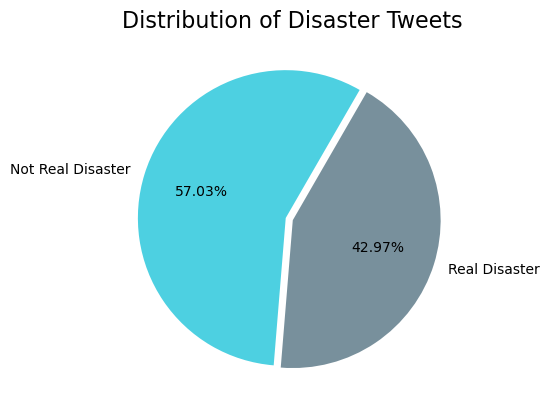

In [199]:
colors = ['#4dd0e1','#78909c']
plt.pie(df_train['target'].value_counts(),
            labels=['Not Real Disaster', 'Real Disaster'],
            autopct='%1.2f%%',
            shadow=False,
            explode=(0.05, 0),
            startangle=60,
            colors=colors);
plt.title(
    label="Distribution of Disaster Tweets", 
    fontdict={"fontsize":16},
);

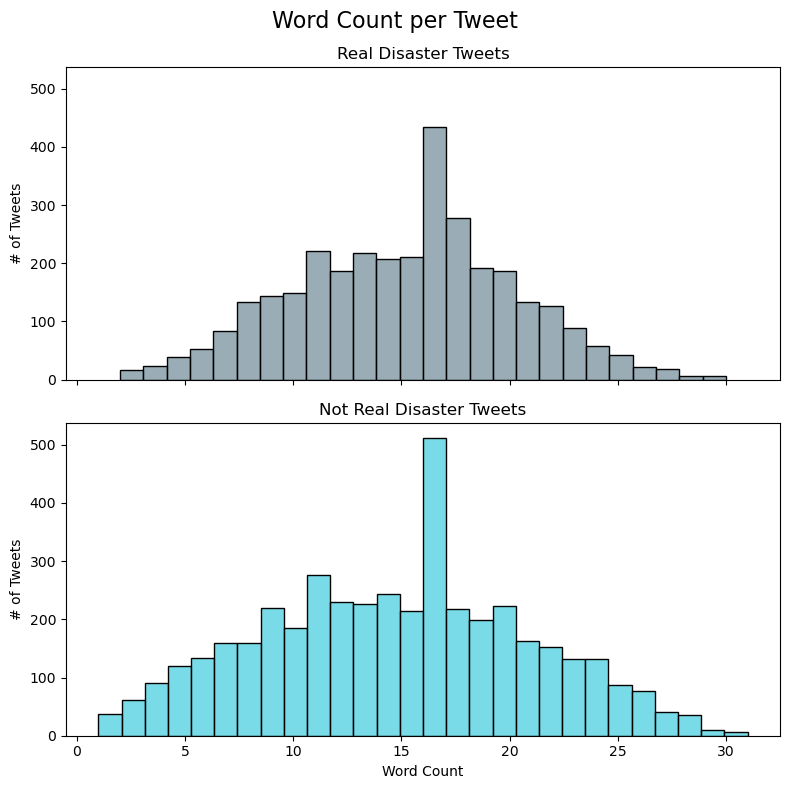

In [200]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_1, x=df_1['text_words'], color='#78909c', ax=axes[0]).set(title='Real Disaster Tweets')
sns.histplot(data=df_0, x=df_0["text_words"], color='#4dd0e1', ax=axes[1]).set(title='Not Real Disaster Tweets')
axes[0].set_xlabel('Word Count')
axes[1].set_xlabel('Word Count')
axes[0].set_ylabel('# of Tweets')
axes[1].set_ylabel('# of Tweets')
fig.suptitle('Word Count per Tweet', fontsize=16);

# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

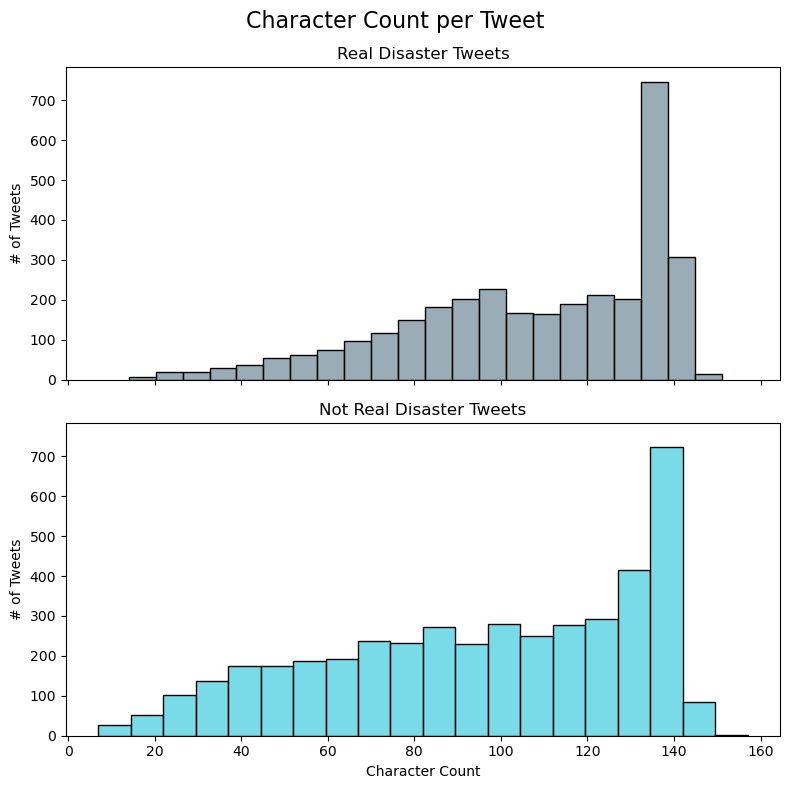

In [201]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_1, x=df_1['character_count'], color='#78909c', ax=axes[0]).set(title='Real Disaster Tweets')
sns.histplot(data=df_0, x=df_0["character_count"], color='#4dd0e1', ax=axes[1]).set(title='Not Real Disaster Tweets')
axes[0].set_xlabel('Character Count')
axes[1].set_xlabel('Character Count')
axes[0].set_ylabel('# of Tweets')
axes[1].set_ylabel('# of Tweets')
fig.suptitle('Character Count per Tweet', fontsize=16);

# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

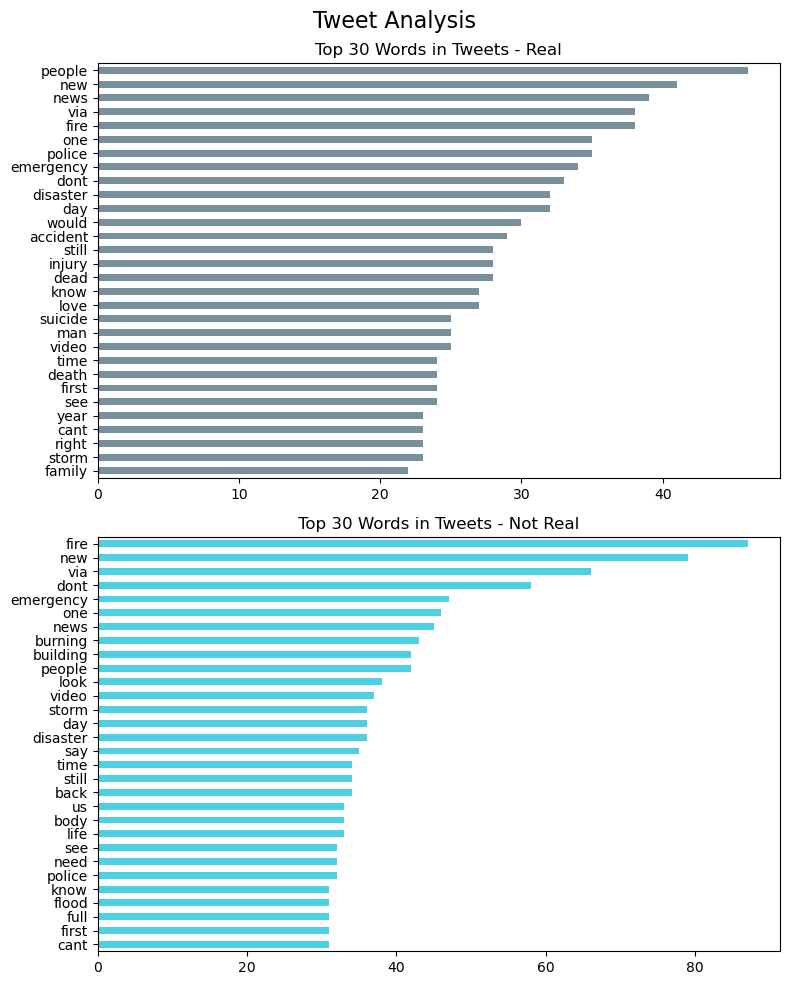

In [202]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_[df_lemm_['target_y'] == 1]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top 30 Words in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();

(df_lemm_[df_lemm_['target_y'] == 0]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top 30 Words in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis(); 

fig.suptitle('Tweet Analysis', fontsize=16);

In [203]:
cvec_stemm = CountVectorizer(stop_words=stopwords)
cvec_stemm.fit(df_filtered_copy["tweet_4_stemm"])
cvec_stemm_data = cvec_stemm.transform(df_filtered_copy["tweet_4_stemm"])
df_stemm = pd.DataFrame(cvec_stemm_data.todense(), columns=cvec_stemm.get_feature_names_out())

In [204]:
df_stemm_ = pd.merge(df_stemm, df_filtered_copy["target"], left_index=True, right_index=True)

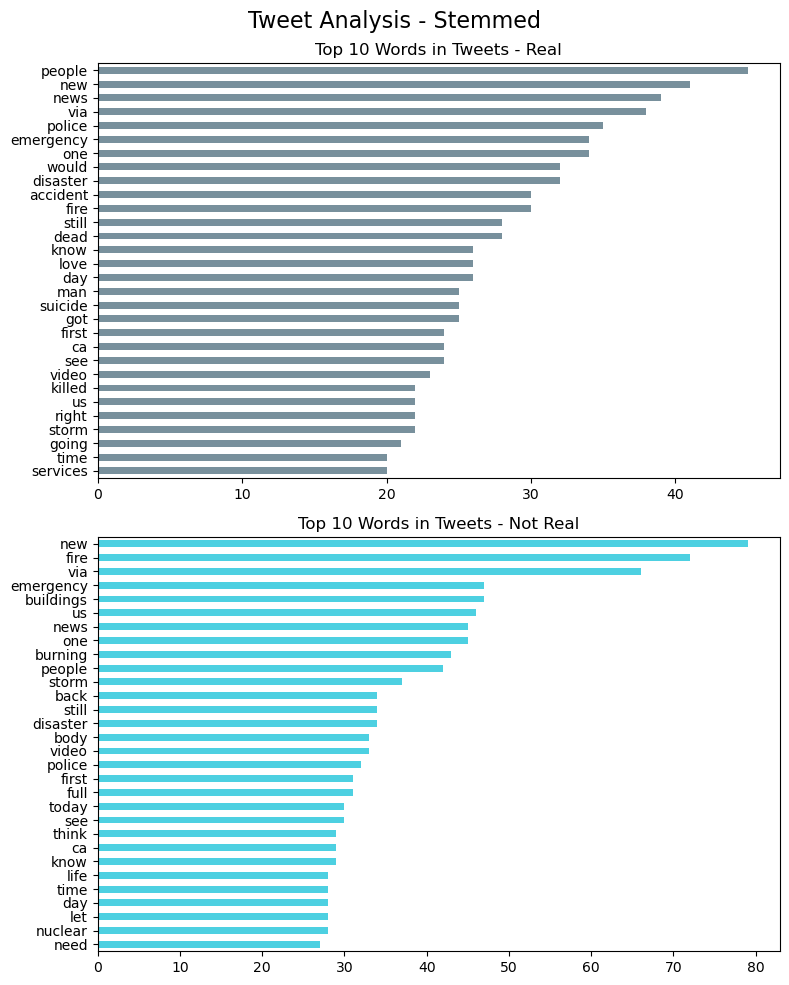

In [205]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_stemm_[df_stemm_['target_y'] == 1]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top 10 Words in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();


(df_stemm_[df_stemm_['target_y'] == 0]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top 10 Words in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis();

fig.suptitle('Tweet Analysis - Stemmed', fontsize=16);

In [206]:
cvec_lemm_2 = CountVectorizer(ngram_range=(2, 2),stop_words=stopwords)
cvec_lemm_2.fit(df_filtered_copy["tweet_4_lemm"])
cvec_lemm_data_2 = cvec_lemm_2.transform(df_filtered_copy["tweet_4_lemm"])
df_lemm_2 = pd.DataFrame(cvec_lemm_data_2.todense(), columns=cvec_lemm_2.get_feature_names_out())

In [207]:
df_lemm_2_ = pd.merge(df_lemm_2, df_filtered_copy["target"], left_index=True, right_index=True)

In [208]:
cvec_lemm_3 = CountVectorizer(ngram_range=(3, 3),stop_words=stopwords)
cvec_lemm_3.fit(df_filtered_copy["tweet_4_lemm"])
cvec_lemm_data_3 = cvec_lemm_3.transform(df_filtered_copy["tweet_4_lemm"])
df_lemm_3 = pd.DataFrame(cvec_lemm_data_3.todense(), columns=cvec_lemm_3.get_feature_names_out())

In [209]:
df_lemm_3_ = pd.merge(df_lemm_3, df_filtered_copy["target"], left_index=True, right_index=True)

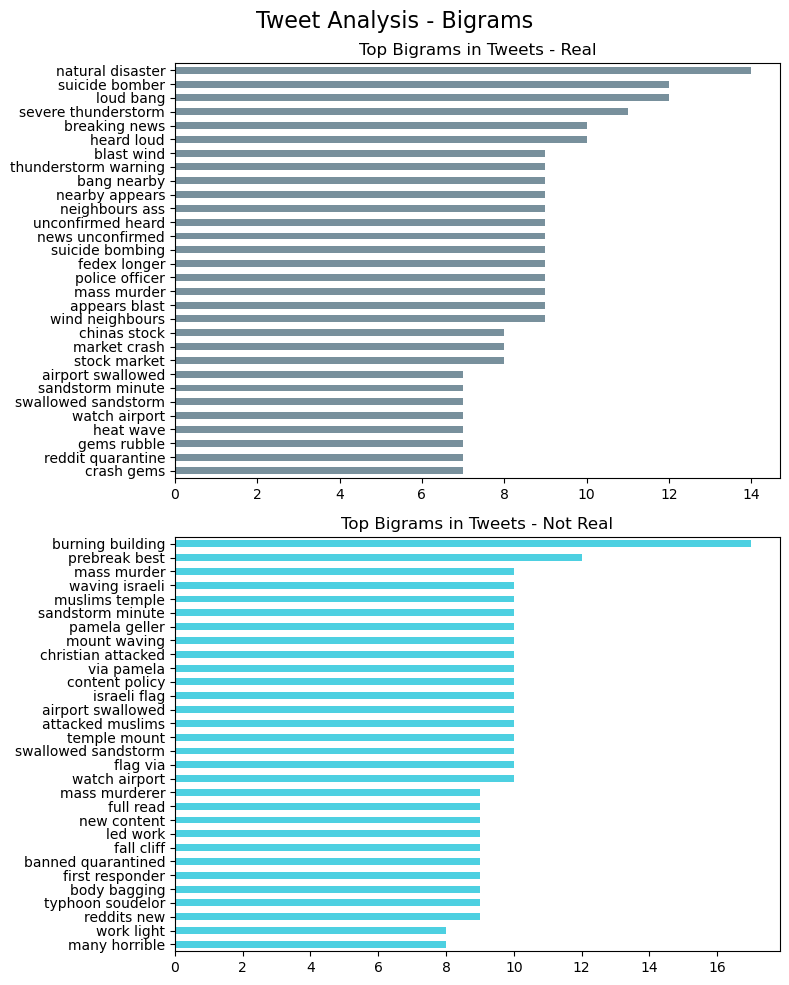

In [210]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_2_[df_lemm_2_['target'] == 1]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Bigrams in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();


(df_lemm_2_[df_lemm_2_['target'] == 0]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Bigrams in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis();

fig.suptitle('Tweet Analysis - Bigrams', fontsize=16);

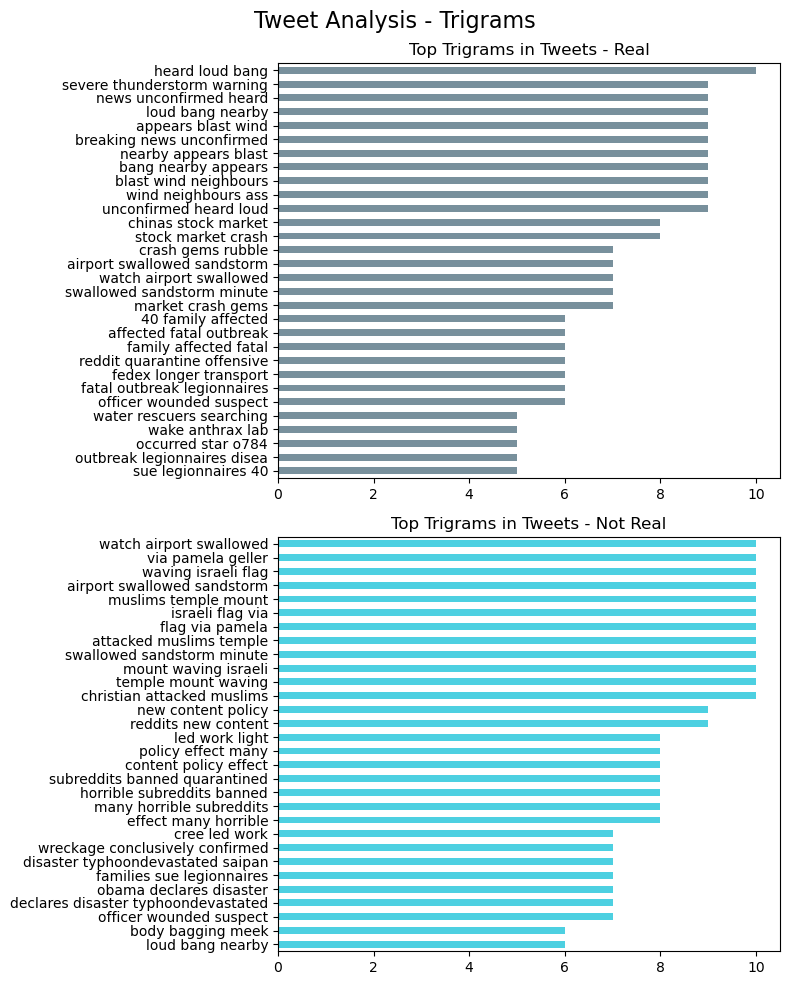

In [211]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_3_[df_lemm_3_['target'] == 1]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();


(df_lemm_3_[df_lemm_3_['target'] == 0]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis();

fig.suptitle('Tweet Analysis - Trigrams', fontsize=16);

#### Findings in our data

In [215]:
# use of hashtags
df_filtered_copy["hashtags"] = list(map(lambda x: x.count("#"), df_filtered_copy['text']))

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_75216/1124088382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_copy["hashtags"] = list(map(lambda x: x.count("#"), df_filtered_copy['text']))


In [216]:
symbol00 = df_filtered_copy.groupby("target")["hashtags"].aggregate(["sum", "mean"]).reset_index()

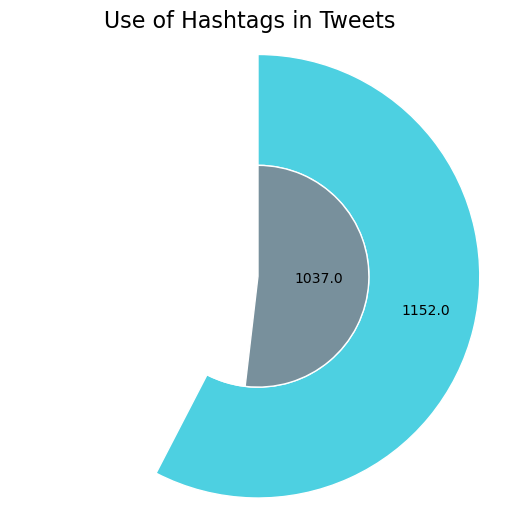

In [217]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol00["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol00["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of Hashtags in Tweets', fontsize=16, y=1.05)
plt.show()

In [218]:
# nu. URLs
df_filtered_copy["urls"] = list(sum(y.count(x) for x in ("www","http","https")) for y in df_filtered_copy['text'])


/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_75216/2259113940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_copy["urls"] = list(sum(y.count(x) for x in ("www","http","https")) for y in df_filtered_copy['text'])


In [219]:
symbol0 = df_filtered_copy.groupby("target")["urls"].aggregate(["sum", "mean"]).reset_index()

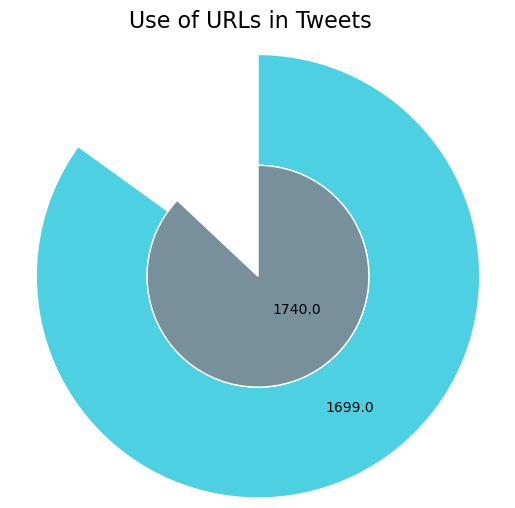

In [220]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol0["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol0["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of URLs in Tweets', fontsize=16, y=1.05)
plt.show()

In [221]:
# use of @
df_filtered_copy["@"] = list(map(lambda x: x.count("@"), df_filtered_copy['text']))

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_75216/2464739631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_copy["@"] = list(map(lambda x: x.count("@"), df_filtered_copy['text']))


In [222]:
symbol1 = df_filtered_copy.groupby("target")["@"].aggregate(["sum", "mean"]).reset_index()
symbol1

,target,sum,mean
0,0,1274,0.444367
1,1,648,0.300836


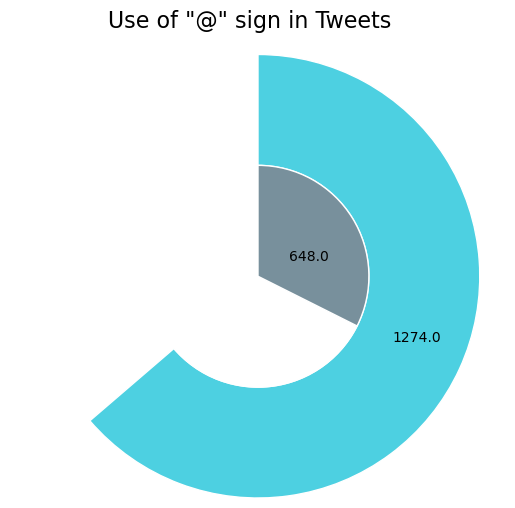

In [223]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol1["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol1["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of "@" sign in Tweets', fontsize=16, y=1.05)
plt.show()

In [224]:
# duplicates
symbol2 = df_train[df_train.duplicated(subset=['text'], keep=False)].groupby("target").count().reset_index()

In [225]:
symbol2

,target,id,keyword,location,text,text_words,character_count,text_lemmatized,text_stemmed
0,0,58,58,30,58,58,58,58,58
1,1,121,116,68,121,121,121,121,121


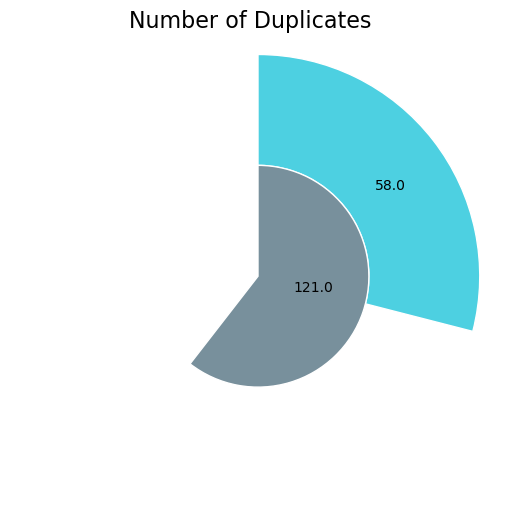

In [226]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol2["id"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol2["id"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Number of Duplicates', fontsize=16, y=1.05)
plt.show()

In [227]:
symbol3 = df_filtered_copy[df_filtered_copy.duplicated(subset=['tweet_4_stemm'], keep=False)].groupby("target").count()
df_filtered_copy[df_filtered_copy.duplicated(subset=['tweet_4_stemm']) == True]

,id,keyword,location,text,target,text_words,character_count,text_lemmatized,text_stemmed,tweet_1_lemm,tweet_1_stemm,tweet_2_lemm,tweet_2_stemm,tweet_3_lemm,tweet_3_stemm,tweet_4_lemm,tweet_4_stemm,hashtags,urls,@
338,485,armageddon,#FLIGHTCITY UK,(OFFICIAL VID) &gt; #DoubleCups &gt;&gt; https...,0,13,141,(OFFICIAL VID) &gt; #DoubleCups &gt;&gt; https...,( OFFICIAL VID ) & gt ; # DoubleCups & gt ; & ...,(OFFICIAL VID) &gt; #DoubleCups &gt;&gt; &gt;...,( OFFICIAL VID ) & gt ; # DoubleCups & gt ; & ...,OFFICIAL VID gt #DoubleCups gtgt gtgt Prod ...,OFFICIAL VID gt # DoubleCups gt gt t...,OFFICIAL VID gt #DoubleCups gtgt gtgt Prod ...,OFFICIAL VID gt # DoubleCups gt gt t...,official vid #doublecups gtgt gtgt prod gtgt #...,official vid # doublecups tcolfkmtzaekk trubgm...,2,2,2
3060,4391,earthquake,#keepthefaith J&J,Earthquake drill ??,1,3,19,Earthquake drill ??,Earthquake drill ? ?,Earthquake drill ??,Earthquake drill ? ?,Earthquake drill,Earthquake drill,Earthquake drill,Earthquake drill,earthquake drill,earthquake drill,0,0,0
3670,5224,fatality,Rafael castillo,fatality,0,1,8,fatality,fatality,fatality,fatality,fatality,fatality,fatality,fatality,fatality,fatality,0,0,0
3696,5259,fatality,Honduras,Fatality ????,0,2,13,Fatality ????,Fatality ? ? ? ?,Fatality ????,Fatality ? ? ? ?,Fatality,Fatality,Fatality,Fatality,fatality,fatality,0,0,0
5274,7536,oil%20spill,"Lyallpur, Pakistan",News@ Refugio oil spill may have been costlier...,1,12,91,News@ Refugio oil spill may have been costlier...,News @ Refugio oil spill may have been costlie...,News@ Refugio oil spill may have been costlier...,News @ Refugio oil spill may have been costlie...,News Refugio oil spill may have been costlier ...,News Refugio oil spill may have been costlier...,News Refugio oil spill may have been costlier ...,News Refugio oil spill may have been costlier...,news refugio oil spill may costlier bigger pro...,news refugio oil spill may costlier bigger pro...,0,1,1
5576,7957,rainstorm,ECSU16,The way you move is like a full on rainstorm a...,0,16,70,The way you move is like a full on rainstorm a...,The way you move is like a full on rainstorm a...,The way you move is like a full on rainstorm a...,The way you move is like a full on rainstorm a...,The way you move is like a full on rainstorm a...,The way you move is like a full on rainstorm a...,The way you move is like a full on rainstorm a...,The way you move is like a full on rainstorm a...,the way move full rainstorm im house cards,the way move full rainstorm i house cards,0,0,0


#### Bernoulli

**Count Vector**

In [228]:
X_lemm = df_filtered_["tweet_4_lemm"]
y = df_filtered["target"]

In [229]:
X_lemm_test = df_test["tweet_4_lemm"]

In [230]:
X_test_test = df_test["text"]

In [231]:
X_lemm.to_csv('X.csv')
y.to_csv('y.csv')

In [232]:
Xn_train, Xn_traintest, y_train, y_traintest = train_test_split(X_lemm,
                                                    y,
                                                    random_state=42, stratify=y)

In [233]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [234]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [235]:
gs_n = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [236]:
gs_n.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [237]:
gs_n.best_score_

0.7943797908032366

In [238]:
print(gs_n.score(Xn_train,y_train))
print(gs_n.score(Xn_traintest,y_traintest))

0.869557490669984
0.8155650319829424


**TFIDF**

In [239]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [240]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [241]:
gs_n_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [242]:
gs_n_tvec.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [243]:
gs_n_tvec.best_score_

0.7943797908032366

In [244]:
print(gs_n_tvec.score(Xn_train,y_train))
print(gs_n_tvec.score(Xn_traintest,y_traintest))

0.869557490669984
0.8155650319829424


#### Logistic Regression

**Count Vector**

In [245]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [246]:
gs_n_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [247]:
gs_n_logr.fit(Xn_train, y_train)

/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [248]:
gs_n_logr.best_score_

0.7959799486875864

In [249]:
print(gs_n_logr.score(Xn_train,y_train))
print(gs_n_logr.score(Xn_traintest,y_traintest))

0.8944375333214857
0.8049040511727079


**TFIDF**

In [250]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [251]:
gs_n_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                pipe_params_tvec, 
                  cv = 5)

In [252]:
gs_n_tvec_logr.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [253]:
gs_n_tvec_logr.best_score_

0.7879831063745806

In [254]:
print(gs_n_tvec_logr.score(Xn_train,y_train))
print(gs_n_tvec_logr.score(Xn_traintest,y_traintest))

0.9113204194064333
0.8033049040511727


#### ADA Boost + Logistic Regression

In [255]:
abc = AdaBoostClassifier(random_state = 42)

In [256]:
cv = CountVectorizer(min_df=2)
cv.fit(Xn_train)

Xn_train_cv = cv.transform(Xn_train)
Xn_test_cv = cv.transform(Xn_traintest)

In [257]:
dt_abc_n = abc.fit(Xn_train_cv, y_train)

In [258]:
print(dt_abc_n.score(Xn_train_cv, y_train))
print(dt_abc_n.score(Xn_test_cv, y_traintest))

0.762217878087791
0.7457356076759062


#### Decision Tree

In [259]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [260]:
dtc = DecisionTreeClassifier()

In [261]:
dt_n = dtc.fit(Xn_train_cv, y_train)

In [262]:
print(dt_n.score(Xn_train_cv, y_train))
print(dt_n.score(Xn_test_cv, y_traintest))

0.9880931224453527
0.7372068230277186


In [263]:
tv = TfidfVectorizer(min_df=2)
tv.fit(Xn_train)

Xn_train_tv = tv.transform(Xn_train)
Xn_test_tv = tv.transform(Xn_traintest)

In [264]:
dt_n_tvec = dtc.fit(Xn_train_tv, y_train)

In [265]:
print(dt_n_tvec.score(Xn_train_tv, y_train))
print(dt_n_tvec.score(Xn_test_tv, y_traintest))

0.987737693264617
0.740405117270789


#### Random Forest

In [266]:
rf = RandomForestClassifier()

In [267]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_n = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_n.fit(Xn_train_cv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [268]:
print(gs_dt_n.score(Xn_train_cv,y_train))
print(gs_dt_n.score(Xn_test_cv,y_traintest))

0.9880931224453527
0.7771855010660981


In [269]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_tvec_n = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_tvec_n.fit(Xn_train_tv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [270]:
print(gs_dt_tvec_n.score(Xn_train_tv,y_train))
print(gs_dt_tvec_n.score(Xn_test_tv,y_traintest))

0.987737693264617
0.7921108742004265


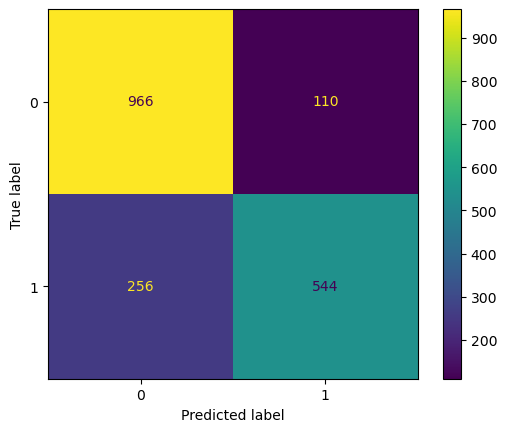

In [271]:
preds = gs_n_logr.predict(Xn_traintest)

cm = confusion_matrix(y_traintest, preds, labels=gs_n_logr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gs_n_logr.classes_)
disp.plot();

## Final evaluation

TN: 966
FP: 110
FN: 256
TP: 544
Sensitivity: 0.68
Specificity: 0.8977695167286245
Validation Accuracy: 0.8049040511727079


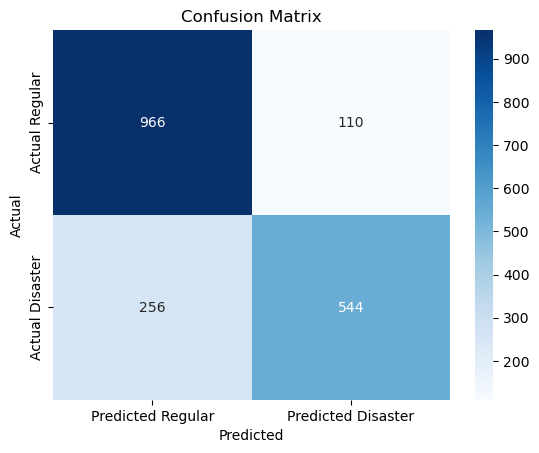

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_75216/712339082.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


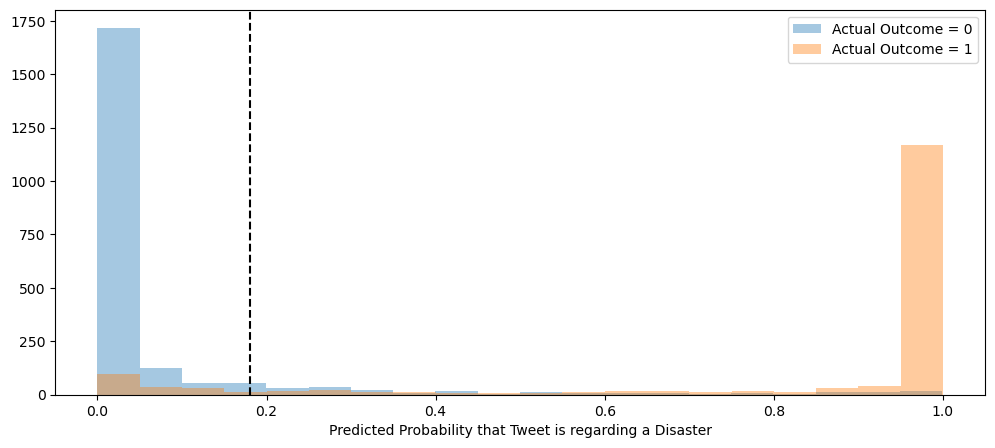

In [297]:
def sklearn_evaluation(model, X_test_in_model, y_test_truth, decision_boundary=0.5):

    predict_probs = model.predict_proba(X_test_in_model)[:,1]

    #preds = (predict_probs > decision_boundary).astype(int)

    conf_matrix = confusion_matrix(y_test_truth, preds)

    tn, fp, fn, tp = conf_matrix.ravel()

    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show();

    reshaped_probs=predict_probs.tolist()
    
    pred_df = pd.DataFrame({'true_values': y_test_truth, 'pred_probs': predict_probs})

    plt.figure(figsize = (12, 5))
    # plot distributions of predicted probabilities by actual values
    for group in pred_df.groupby('true_values'):
        sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    
    # Add cutoff line
    plt.axvline(0.18, color = 'black', linestyle = '--')

    plt.xlabel('Predicted Probability that Tweet is regarding a Disaster')
    plt.legend();

sklearn_evaluation(gs_n, Xn_traintest, y_traintest)

## Submission

In [272]:
predictions = gs_n.predict(X_lemm_test)

In [273]:
import pickle

In [275]:
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_lemm_test, f)

In [276]:
predictions_test = gs_n.predict(X_test_test)

In [ ]:
submission_test = pd.DataFrame({'id':df_test.id, 'target':predictions_test})

In [ ]:
submission_test["target"].value_counts()

In [ ]:
submission_ = submission_test.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.DataFrame({'id':df_test.id, 'target':predictions})

In [ ]:
submission["target"].value_counts()

In [ ]:
submission__ = submission.to_csv('submission_cleaned.csv', index=False)